In [46]:
initial_path = 'peptide-QML/'
# initial_path = '../'

In [47]:
import numpy as np

In [48]:
import sys
sys.path.append(initial_path)

from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

In [49]:
import pennylane as qml

# Data

In [50]:
file_path = initial_path + 'data/energies/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(file_path)
score_list = np.array(number_list)/1000
vector_list = np.array([f.string_to_vector(string) for string in string_list]) # one hot encoding

In [51]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]) # flatten
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1]*X_validation.shape[2]) # flatten

In [52]:
# Define the dataset
input_data = ptm.torch.tensor(X, dtype=ptm.torch.float64) 
target_data = ptm.torch.tensor(Y, dtype=ptm.torch.float64).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation, dtype=ptm.torch.float64)
target_validation = ptm.torch.tensor(Y_validation, dtype=ptm.torch.float64).view(-1, 1)

# Quantum node

In [88]:
n_aminoacids = len(string_list[0])

In [60]:
quantum_layer = qn.circuit(
                                n_qubits = n_aminoacids, 
                                device = "default.qubit",
                                device_options = {'shots': 10000},
                                qnode_options = {'interface': 'torch'},
                                embedding = qn.parts.AngleEmbedding, 
                                ansatz = qn.parts.Ansatz_11,
                                measurement = qn.parts.exp_Z(1),
                                n_layers = 25,
                                wrapper_qlayer = pw.QLayer,
                            )

In [ ]:
quantum_layer.draw(size=(50,3))

# Hybrid model

In [62]:
input_dim = input_data.size(1)

n_pre_classical_layers = 4
layers_dim = np.linspace(n_aminoacids, input_dim, 4).astype(int)

In [63]:
layers = []
for i in range(1, len(layers_dim)):
    layers += [ptm.nn.Linear(layers_dim[-1*i], layers_dim[-1*(i+1)]), ptm.nn.ReLU()]
layers += [ptm.nn.Linear(layers_dim[0], layers_dim[0])]
layers += [quantum_layer()]
# layers += [nn.Linear(1, 1)]
# layers += [nn.Linear(2, 4), nn.ReLU()]
# layers += [nn.Linear(4, 1)]

In [64]:
# Create model and set data:
model = ptm.pytorch_model(layers)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [65]:
# train the model
model.train(num_epochs=2)

Epoch [0/2], Loss: 1.9369, Loss validation: 1.7408


KeyboardInterrupt: 

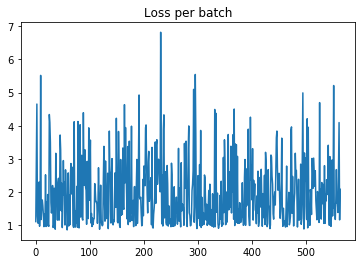

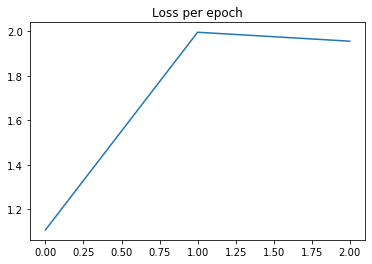

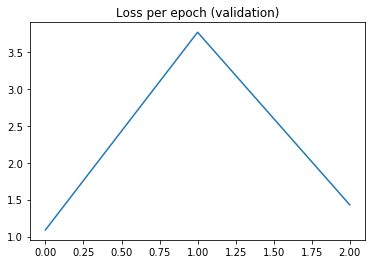

In [ ]:
# plot the losses of the trainig loop
model.plot_losses()

In [ ]:
#save model
name_notebook = "0801-small_hybrid_model_1qm_shots.ipynb"  

version = model.save_state_dict(name_notebook=name_notebook, initial_path=initial_path)

Model saved as peptide-QML/Notebooks/models/0801/0801-small_hybrid_model_1qm_shots_0.pth


In [ ]:
# push changes to git
!cd peptide-QML && git add . && git commit -m "data trained model" && git push

[main aeac830] data trained model
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 Notebooks/models/0801/0801-small_hybrid_model_1qm_shots_0.pth
Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 24 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 473 bytes | 473.00 KiB/s, done.
Total 5 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:raulconchello/peptide-QML.git
   74060c3..aeac830  main -> main


In [ ]:
#load model
model.load_state_dict(name_notebook=name_notebook, version=version, initial_path=initial_path)

Model loaded from peptide-QML/Notebooks/models/0731/0731-small_hybrid_model_1qm_shots_2.pth


In [ ]:
# print validation
model.print_validation()

i: 0, 	 target: -0.074, 	 output: -0.106, 	 loss: 0.434
i: 1, 	 target: 0.218, 	 output: -0.108, 	 loss: 1.494
i: 2, 	 target: 0.112, 	 output: -0.098, 	 loss: 1.877
i: 3, 	 target: -0.028, 	 output: -0.083, 	 loss: 1.927
i: 4, 	 target: -0.103, 	 output: -0.116, 	 loss: 0.127
i: 5, 	 target: -0.058, 	 output: -0.109, 	 loss: 0.880
i: 6, 	 target: -0.076, 	 output: -0.093, 	 loss: 0.221
i: 7, 	 target: 0.183, 	 output: -0.119, 	 loss: 1.650
i: 8, 	 target: -0.048, 	 output: -0.110, 	 loss: 1.299
i: 9, 	 target: -0.031, 	 output: -0.128, 	 loss: 3.185
i: 10, 	 target: 0.240, 	 output: -0.110, 	 loss: 1.458
i: 11, 	 target: -0.075, 	 output: -0.104, 	 loss: 0.384
i: 12, 	 target: 0.136, 	 output: -0.095, 	 loss: 1.693
i: 13, 	 target: -0.028, 	 output: -0.121, 	 loss: 3.276
i: 14, 	 target: 0.165, 	 output: -0.127, 	 loss: 1.771
i: 15, 	 target: -0.074, 	 output: -0.127, 	 loss: 0.722
i: 16, 	 target: 0.029, 	 output: -0.109, 	 loss: 4.703
i: 17, 	 target: -0.079, 	 output: -0.108, 	 los